# Deep Reinforcement Learning — Doom Agent (SS2025)

Welcome to the last assignment for the **Deep Reinforcement Learning** course (SS2025). In this notebook, you"ll implement and train a reinforcement learning agent to play **Doom**.

You will:
- Set up a custom VizDoom environment with shaped rewards
- Train an agent using an approach of your choice
- Track reward components across episodes
- Evaluate the best model
- Visualize performance with replays and GIFs
- Export the trained agent to ONNX to submit to the evaluation server

In [1]:
# Clone repo
#!git clone https://$token@github.com/gerkone/jku.wad.git
#%cd jku.wad

In [2]:
# Install the dependencies
#!pip install torch numpy matplotlib vizdoom portpicker gym onnx

In [3]:
from IPython import get_ipython
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

In [4]:
from datetime import datetime
from collections import deque
from copy import deepcopy
import random
from torch import nn
from doom_arena import VizdoomMPEnv

In [5]:
from agents.utils import *
from agents.visualizations import *
from agents.helpers import *
from agents.dqn import EfficientDQN, epsilon_greedy, soft_update_target_network, LargeDQN, SmallDQN

In [6]:
rng = np.random.default_rng(100)

In [7]:
# Create folder for training
training_id = datetime.now().strftime("%Y%m%d_%H%M%S")
training_folder = os.path.join("runs", training_id)
#training_folder = os.path.join("runs", "Testing")

os.makedirs(training_folder, exist_ok=True)
print("Using folder:", training_folder)

# Define loggers
logger = Logger(training_folder, also_print=True)
activation_logger = ActivationLogger(training_folder, filename="activations.txt", also_print=False)

Using folder: runs/20250622_120122


## Environment configuration

ViZDoom supports multiple visual buffers that can be used as input for training agents. Each buffer provides different information about the game environment, as seen from left to right:


Screen
- The default first-person RGB view seen by the agent.

Labels
- A semantic map where each pixel is tagged with an object ID (e.g., enemy, item, wall).

Depth
- A grayscale map showing the distance from the agent to surfaces in the scene.

Automap
- A top-down schematic view of the map, useful for global navigation tasks.

![buffers gif](https://vizdoom.farama.org/_images/vizdoom-demo.gif)

In [8]:
USE_GRAYSCALE = False  # ← flip to False for RGB

PLAYER_CONFIG = {
    # NOTE: "algo_type" defaults to POLICY in evaluation script!
    "algo_type": "QVALUE",  # OPTIONAL, change to POLICY if using policy-based (eg PPO)
    "n_stack_frames": 1, #4, # 1 # Temporal information
    "extra_state": ["depth"], #["labels"],#, "automap"], #["depth", "labels", "automap"],
    "hud": "none",
    "crosshair": True,
    "screen_format": 8 if USE_GRAYSCALE else 0,
}

In [9]:
# TODO: environment training paramters
N_STACK_FRAMES = 1 # 4 does not work yet!
NUM_PLAYERS = 4 #3
NUM_BOTS = 6 #1, #6
EPISODE_TIMEOUT = 1500 # 2000
# TODO: model hyperparams
GAMMA = 0.95
EPISODES = 200 #2 # 500
BATCH_SIZE = 128
REPLAY_BUFFER_SIZE = 15_000
LEARNING_RATE = 1e-5
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.998 # 0.987
N_EPOCHS = 20
FRAME_SKIPPING = 0
FRAME_SKIPPING_STOP = 100
DEBUG = True
PRINT_EVERY = 50
VIDEO_DURING_TRAINING = True
EVALUATION_EVERY = 50

In [10]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print("Device:", device)

DTYPE = torch.float32

obs_states = ExtraStates(PLAYER_CONFIG["extra_state"] + ["screen"], num_frames = N_STACK_FRAMES)

reward_fn = YourReward(num_players=NUM_PLAYERS)

def build_env():
    env = VizdoomMPEnv(
        num_players=NUM_PLAYERS, # 4 is max
        num_bots=NUM_BOTS,
        bot_skill=1, # Increased difficulty
        doom_map="TRNM",  # ROOM = NOTE simple, small map; other options: TRNM, TRNMBIG
        extra_state=PLAYER_CONFIG["extra_state"],  # see info about states at the beginning of "Environment configuration" above
        episode_timeout=EPISODE_TIMEOUT,
        n_stack_frames=PLAYER_CONFIG["n_stack_frames"],
        crosshair=PLAYER_CONFIG["crosshair"],
        hud=PLAYER_CONFIG["hud"],
        screen_format=PLAYER_CONFIG["screen_format"],
        reward_fn=reward_fn,
        seed = rng.integers(1, 2000, NUM_PLAYERS),
        ticrate = 35#*3,
    )
    return env

env = build_env()
with suppress_output(): # Reset to get player and game information
    _ = env.reset()

Device: mps
Environment Seed: [1534 1670  249 1193]
Host 55138
Player 55138


## Agent

Implement **your own agent** in the code cell that follows.

* In `agents/dqn.py` and `agents/ppo.py` you’ll find very small **skeletons**—they compile but are meant only as reference or quick tests.  
  Feel free to open them, borrow ideas, extend them, or ignore them entirely.
* The notebook does **not** import those files automatically; whatever class you define in the next cell is the one that will be trained.
* You may keep the DQN interface, switch to PPO, or try something else.
* Tweak any hyper-parameters (`PLAYER_CONFIG`, ε-schedule, optimiser, etc.) and document what you tried.


In [11]:
# ================================================================
# Initialise your networks and training utilities
# ================================================================
env_actions = EnvActions(env, rng=rng)

# main Q-network
model = EfficientDQN(
    input_dim = 0,
    action_space=env_actions.action_space,
    obs_state_infos=obs_states,
).to(device, dtype=DTYPE)

# Load a model from file
#model = model.load_model("runs/20250621_182219/best_model_20250621_182229.pt").to(device, dtype=DTYPE)

Initialized model with 1345433 parameters!


In [12]:
target_model  = deepcopy(model).to(device, dtype=DTYPE)
optimizer  = torch.optim.AdamW(target_model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
scheduler  = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=50, eta_min=1e-8)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)

## Example of environment

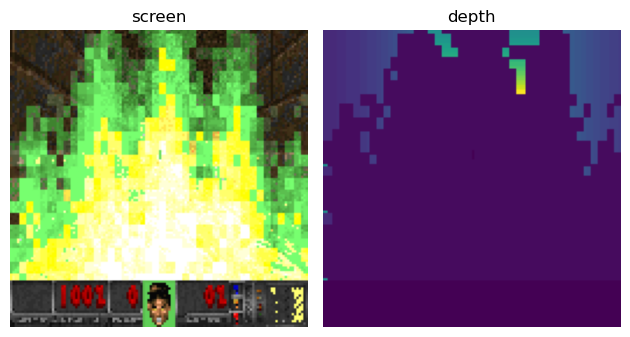

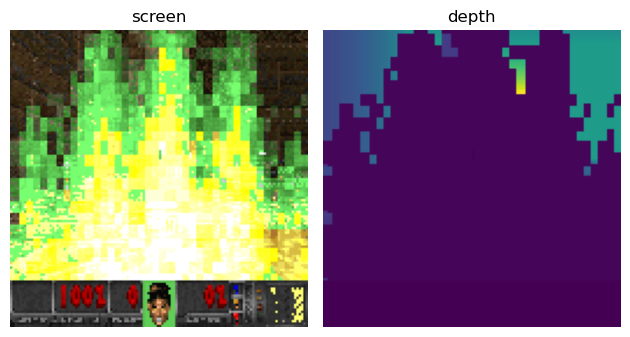

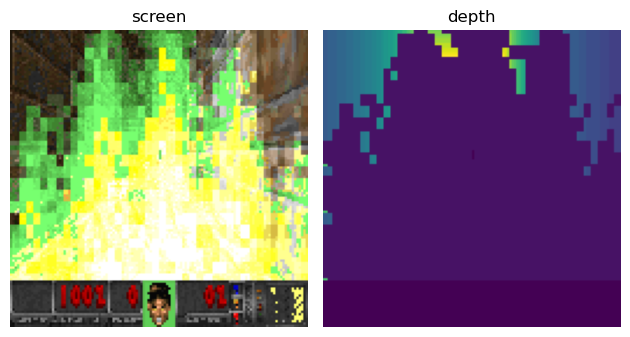

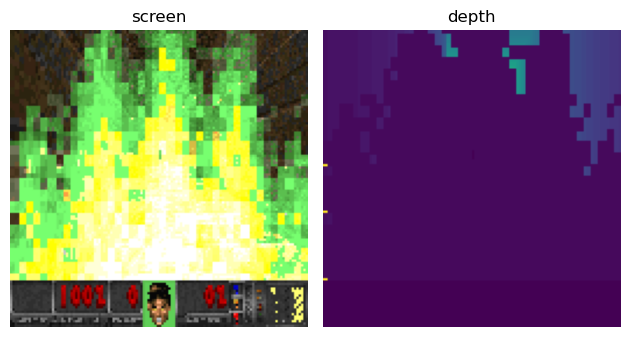

In [13]:
# Reset environment
with suppress_output():
    obs_test: list = env.reset()
    
for player in range(len(obs_test)):
    plot_images(obs_test[player], obs_states.get_dims())

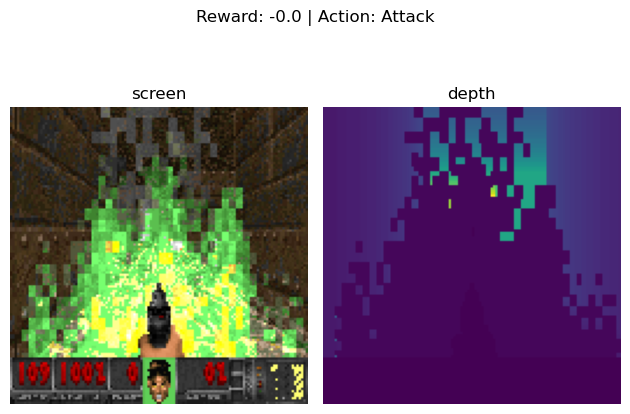

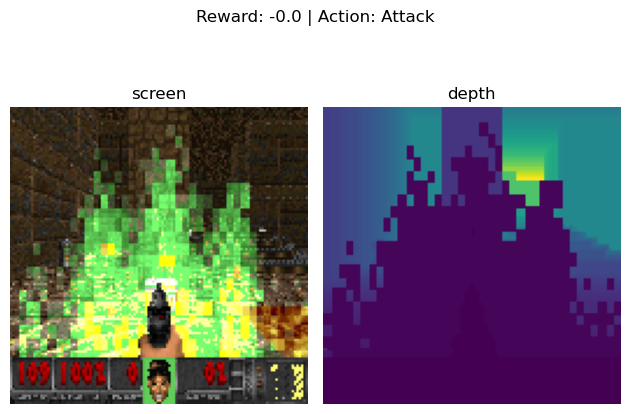

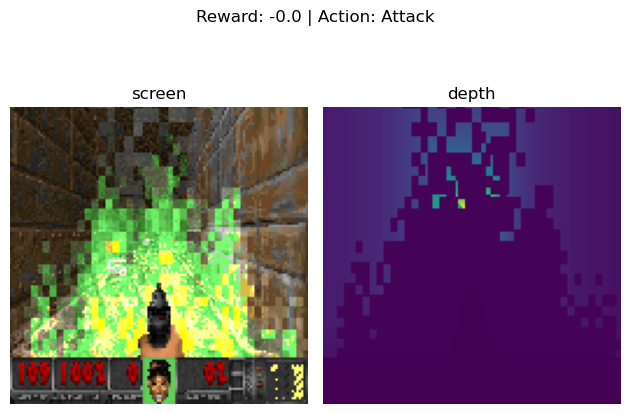

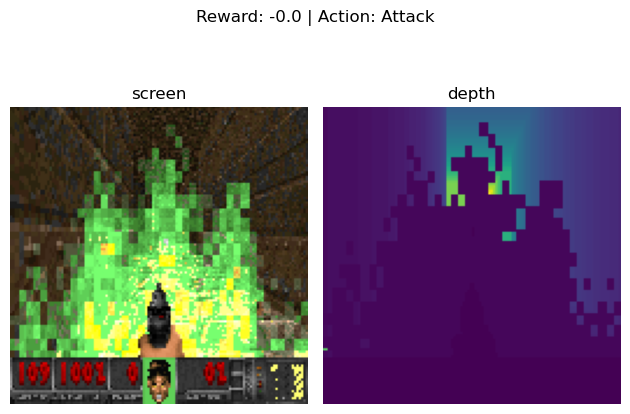

In [14]:
# Iterate 60 steps
STEPS = 30

with torch.no_grad():
    for i in range(STEPS):
        actions = env_actions.get_random_action(NUM_PLAYERS)
        #actions = env_actions.get_action_value(1, NUM_PLAYERS)
        #actions = epsilon_greedy(env, model, obs_test, 0.5, env_actions, device, DTYPE, debug=True) # 50% random actions by model
        actions = epsilon_greedy(env, model, torch.rand_like(torch.stack(obs_test)), 0, env_actions, device, DTYPE, debug=False) # model fully random
        obs_test, reward = env.step(actions)[0:2]

    for player in range(env.num_players):
        action_print = [actions] if isinstance(actions, int) else actions
        plot_images(obs_test[player], obs_states.get_dims(), **{"title": f"Reward: {reward[player]:.1f} | Action: {env_actions.get_action_name(action_print[player])}"})


### Example of Reward

In [15]:
player_idx = rng.integers(env.num_players)

player_game_vars = env.envs[player_idx].unwrapped._game_vars
player_game_vars_pre = env.envs[player_idx].unwrapped._game_vars_pre
reward = reward_fn(0, player_game_vars, player_game_vars_pre, 0)
print(f"Reward: {np.sum(reward)} | {reward}")
for key, value_now, value_old in zip(player_game_vars, player_game_vars.values(), player_game_vars_pre.values()):   
    print(f"{key+':':<25}{value_now:.0f} | {value_old:.0f}")

Reward: -0.005 | (0.0, 0.0, -0.0, 0, 0.0, -0.005, 0.0)
HEALTH:                  100 | 100
AMMO3:                   0 | 0
FRAGCOUNT:               0 | 0
ARMOR:                   0 | 0
HITCOUNT:                0 | 0
HITS_TAKEN:              0 | 0
DEAD:                    0 | 0
DEATHCOUNT:              0 | 0
DAMAGECOUNT:             0 | 0
DAMAGE_TAKEN:            0 | 0
KILLCOUNT:               0 | 0
SELECTED_WEAPON:         2 | 2
SELECTED_WEAPON_AMMO:    109 | 109
POSITION_X:              1090 | 1090
POSITION_Y:              1216 | 1216


## Training loop

In [16]:
def analyze_model_tensors(episode: int, obs_clean: tuple[torch.Tensor], model: nn.Module, model_sequence: list = [None, 0, 1, 1], print_once: bool = False):    
    rand_tensor = torch.rand(size=torch.stack(obs_clean).shape).to("cpu").split(obs_states.get_dims(return_dict=False), dim=1)
    
    value, advantage = activation_logger.log_model_activations(rand_tensor, model, model_sequence, episode=episode, return_activations_from_idx=-2, print_once=print_once)
    q_values = (value + advantage - advantage.mean(dim=1, keepdim=True)).to(dtype=DTYPE)
    q_actions = q_values.argmax(dim=1).to(dtype=DTYPE)
    
    log_qvals = activation_logger.analyze_activations(q_values, episode, title="Qvalues", print_once=print_once)
    log_qacts = activation_logger.analyze_activations(q_actions, episode, title="Actions", print_once=print_once)
    activation_logger.log(log_qvals + "\n" + log_qacts, improve_file_output=True)

N_STACK_FRAMES: 1, NUM_PLAYERS: 4, NUM_BOTS: 6, EPISODE_TIMEOUT: 1500, GAMMA: 0.95, EPISODES: 200, BATCH_SIZE: 128, REPLAY_BUFFER_SIZE: 15000, LEARNING_RATE: 1e-05, EPSILON_START: 1.0, EPSILON_END: 0.1, EPSILON_DECAY: 0.998, N_EPOCHS: 20, FRAME_SKIPPING: 0, FRAME_SKIPPING_STOP: 100, DEBUG: True, PRINT_EVERY: 50, VIDEO_DURING_TRAINING: True, EVALUATION_EVERY: 50algo_type: QVALUE, n_stack_frames: 1, extra_state: ['depth'], hud: none, crosshair: True, screen_format: 0


Training:   0%|          | 0/200 [00:00<?, ? episode/s]

12:01:27 | Episode: 0 | Steps done: 0 | Gathering rollout (currently 0)
12:01:42 | Episode: 0 | Training for 20 epochs
12:01:45 | Episode: 0 | Updating target network...
12:01:45 | Episode: 0 | Rewards:
	Reward: [ 9. 47. 94. 38.] | Avg Reward: 47.0 | Loss: 0.0299 | ε: 0.998 | LR: 9.99e-06
	Metrics - ['frags: 0', 'hits: 48', 'damage_taken: -1', 'movement: 0', 'ammo_efficiency: 5', 'survival: -7', 'health_pickup: 2']
	Actions - Noop: 257, Move Forward: 1079, Attack: 1652, Move Left: 569, Move Right: 534, Turn Left: 866, Turn Right: 798, Jump: 245
12:01:45 | Episode: 0 | Replaying animation...
12:02:29 | Episode: 0 | Running quick evaluation...
12:02:31 | Episode: 1 | Steps done: 1500 | Gathering rollout (currently 5996)
12:02:46 | Episode: 1 | Training for 20 epochs
12:02:47 | Episode: 1 | Updating target network...
12:02:47 | Episode: 1 | Rewards:
	Reward: [126.  -5.  99.  -2.] | Avg Reward: 51.0 | Loss: 0.0306 | ε: 0.996 | LR: 9.96e-06
	Metrics - ['frags: 0', 'hits: 56', 'damage_taken:

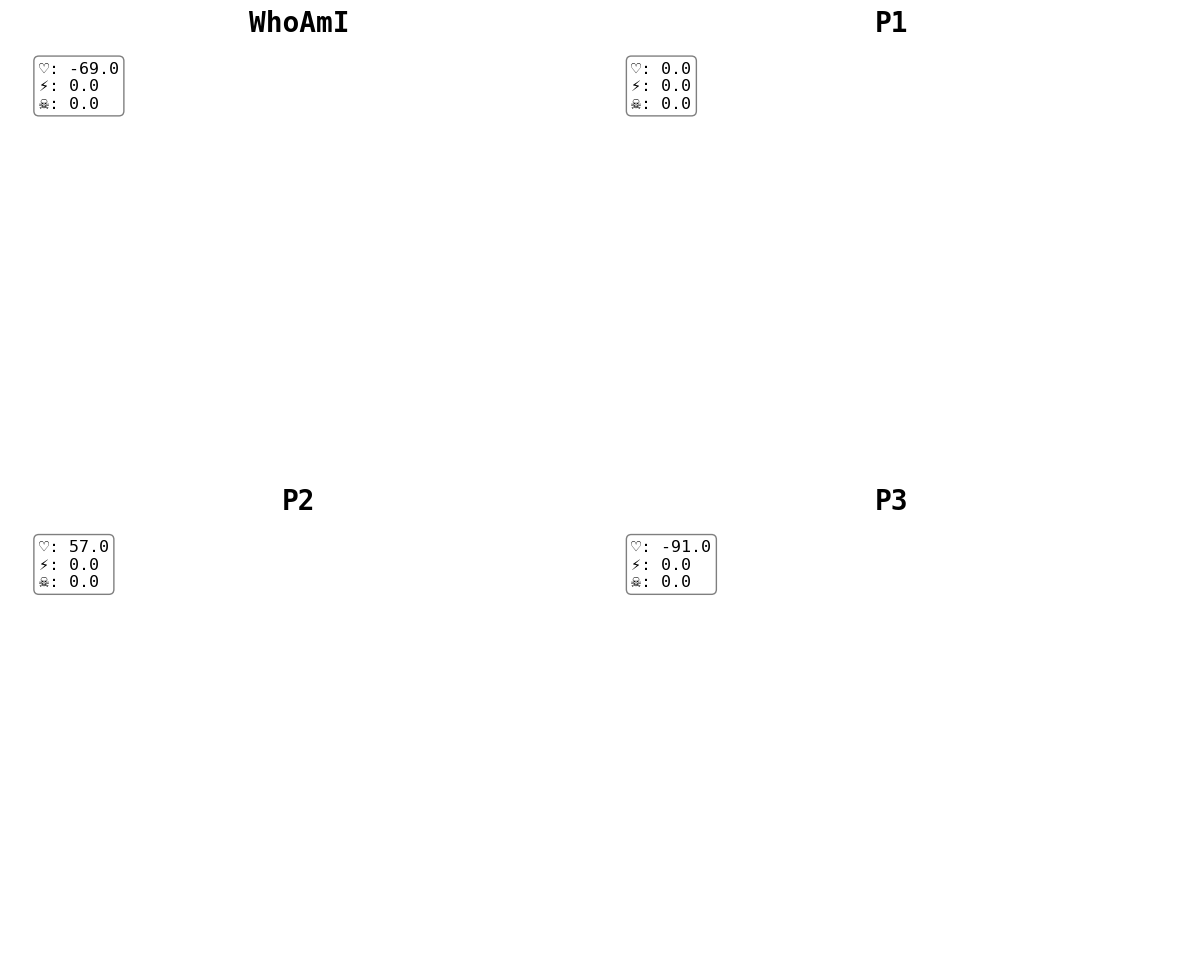

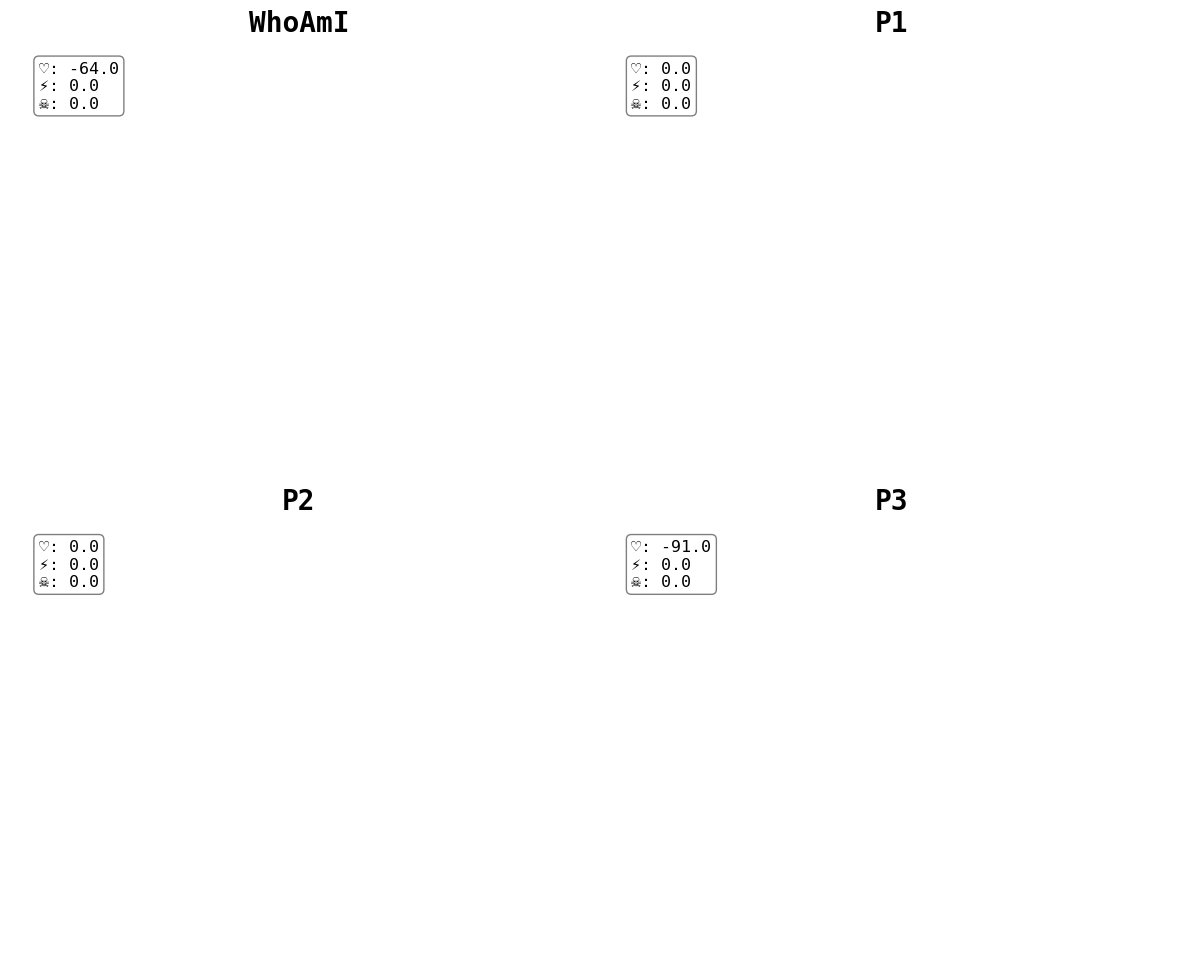

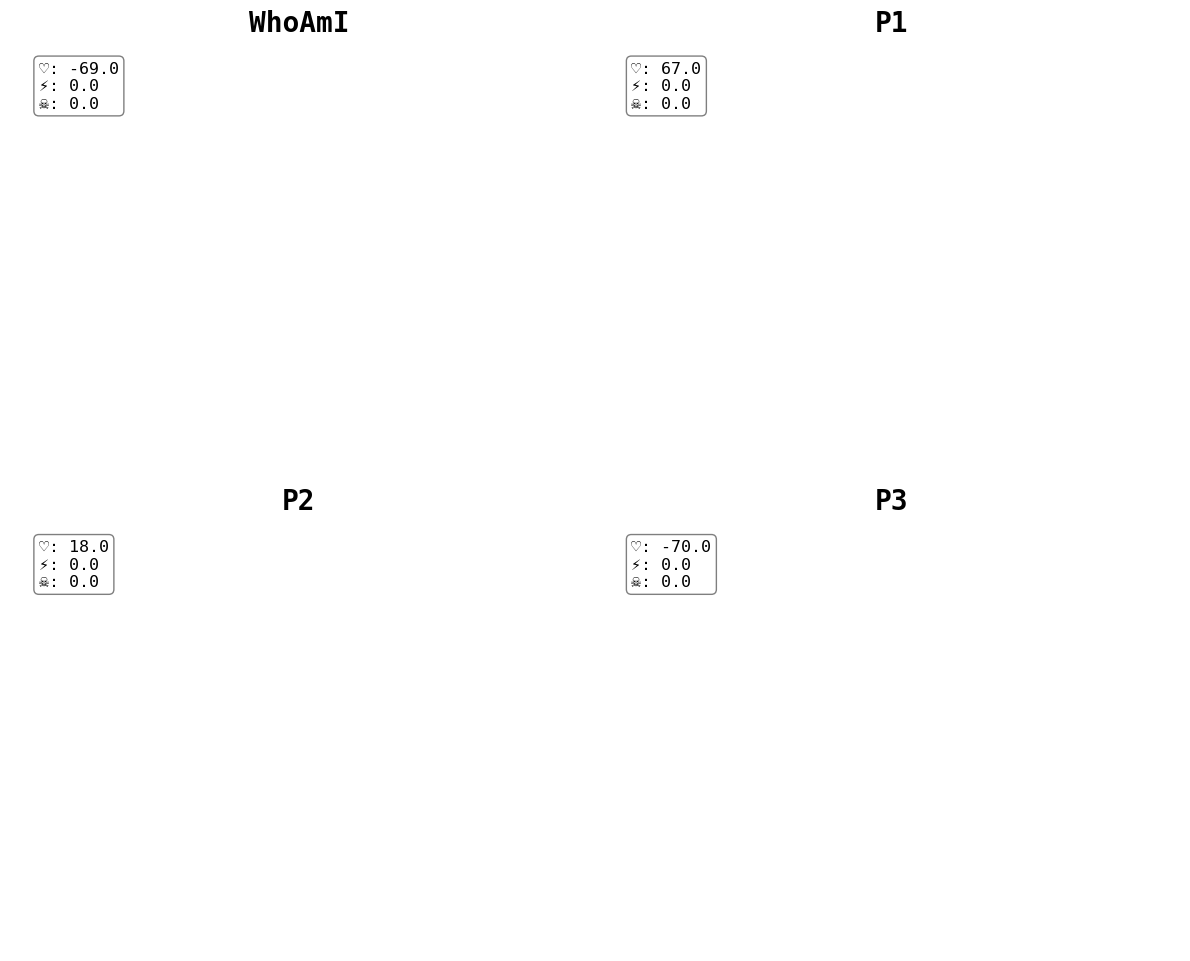

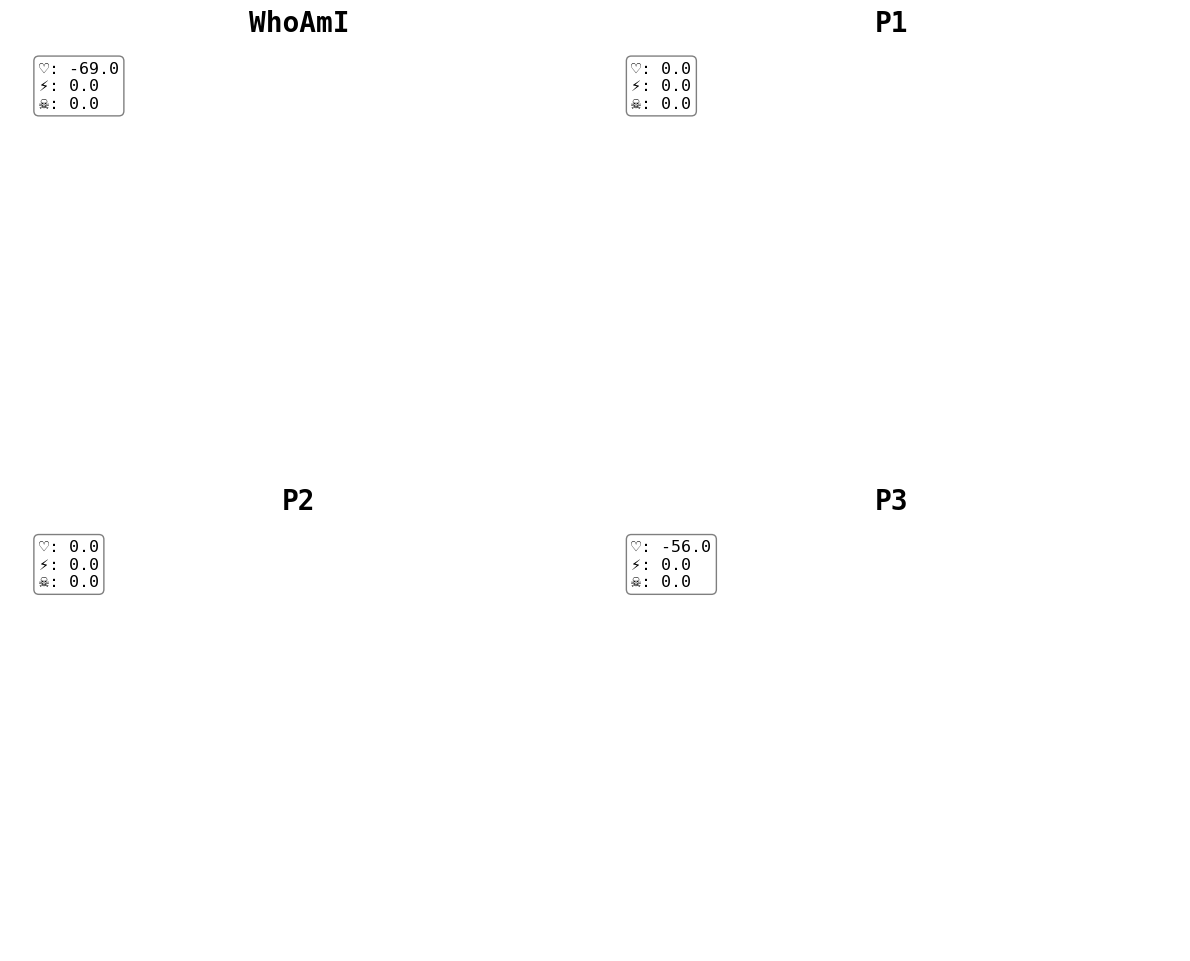

In [17]:
# ---------------------  TRAINING LOOP  ----------------------
training_info_str = (
    f"N_STACK_FRAMES: {N_STACK_FRAMES}, "
    f"NUM_PLAYERS: {NUM_PLAYERS}, "
    f"NUM_BOTS: {NUM_BOTS}, "
    f"EPISODE_TIMEOUT: {EPISODE_TIMEOUT}, "
    f"GAMMA: {GAMMA}, "
    f"EPISODES: {EPISODES}, "
    f"BATCH_SIZE: {BATCH_SIZE}, "
    f"REPLAY_BUFFER_SIZE: {REPLAY_BUFFER_SIZE}, "
    f"LEARNING_RATE: {LEARNING_RATE}, "
    f"EPSILON_START: {EPSILON_START}, "
    f"EPSILON_END: {EPSILON_END}, "
    f"EPSILON_DECAY: {EPSILON_DECAY}, "
    f"N_EPOCHS: {N_EPOCHS}, "
    f"FRAME_SKIPPING: {FRAME_SKIPPING}, "
    f"FRAME_SKIPPING_STOP: {FRAME_SKIPPING_STOP}, "
    f"DEBUG: {DEBUG}, "
    f"PRINT_EVERY: {PRINT_EVERY}, "
    f"VIDEO_DURING_TRAINING: {VIDEO_DURING_TRAINING}, "
    f"EVALUATION_EVERY: {EVALUATION_EVERY}"
)

training_info_str += ', '.join([f"{k}: {v}" for k, v in PLAYER_CONFIG.items()])

logger.log(training_info_str, improve_file_output=True)

# Training settings
q_loss_list, epsilon_history = [], []
reward_history = {player: [] for player in range(env.num_players)}
best_reward = float("-inf")
best_model = None

epsilon = EPSILON_START 
steps_done = 0


with TqdmProgress(total=EPISODES) as progress_bar:
    for episode in progress_bar:
        
        episode_action_counter = ActionCounter()
        progress_bar.set_description(episode)
        
        with suppress_output():
            #obs = torch.stack([env.reset() for env in environments.values()])
            obs: torch.Tensor = env.reset()
        
        # Episode variables for each player
        episode_metrics = {player: {"frags": 0, "hits": 0, "damage_taken": 0, "movement": 0, "ammo_efficiency": 0, "survival": 0, "health_pickup": 0} for player in range(env.num_players)}
        episode_reward = {player: 0.0 for player in range(env.num_players)}

        dones = [False]
        model.eval()
        
        episode_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Steps done: {steps_done} | Gathering rollout (currently {len(replay_buffer)})"
        logger.log(episode_msg)
        
        # ───────── rollout ─────────────────────────────────────────────
        while not all(dones):
            
            # Skip Frames (Testing - I am aware that in the original paper they stacked the images. I want to get many more steps at the beginning)
            act = epsilon_greedy(env, model, obs, epsilon, env_actions, device, DTYPE, episode_action_counter)
            
            max_skip_steps = max(FRAME_SKIPPING * (episode < FRAME_SKIPPING_STOP), 1)
            for skip_steps in range(max_skip_steps):
                if all(dones):
                    break
                next_obs, reward, dones, _ = env.step(act)
                steps_done += 1

            # ----- reward definition ----------------
            for player_idx in range(env.num_players):
                episode_reward[player_idx] += np.sum(reward[player_idx]) # Should be a list with one value
                
                if dones[player_idx]:
                    break
                
                reward_components = reward_fn(None, env.envs[player_idx].unwrapped._game_vars, env.envs[player_idx].unwrapped._game_vars_pre, None)

                if len(reward_components) >= 6:
                    episode_metrics[player_idx]["frags"] += reward_components[0]
                    episode_metrics[player_idx]["hits"] += reward_components[1]
                    episode_metrics[player_idx]["damage_taken"] += reward_components[2]
                    episode_metrics[player_idx]["movement"] += reward_components[3]
                    episode_metrics[player_idx]["ammo_efficiency"] += reward_components[4]
                    episode_metrics[player_idx]["survival"] += reward_components[5]
                    episode_metrics[player_idx]["health_pickup"] += reward_components[6]
            
                # ----- buffer and environment handling ----------------
                if env.num_players == 1:
                    act = [act]
                    
                replay_buffer.append((obs[player_idx], act[player_idx], reward[player_idx], next_obs[player_idx], dones[player_idx]))

            obs = next_obs
            
        [reward_history[player_idx].append(reward) for player_idx, reward in episode_reward.items()] # Append rewards for every player
        epsilon_history.append(epsilon)

        # ───────── learning step (experience replay) ──────────────────
        if len(replay_buffer) >= BATCH_SIZE:

            model.train()
            train_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Training for {N_EPOCHS} epochs"
            logger.log(train_msg)
            
            for epoch in range(N_EPOCHS):

                batch = random.sample(replay_buffer, BATCH_SIZE)
                states, actions, rewards, next_states, dones = zip(*batch)

                # Convert to tensors for training
                states = torch.stack(states).to(device, DTYPE)
                next_states = torch.stack(next_states).to(device, DTYPE)
                actions = torch.tensor(actions, device=device)
                rewards = torch.tensor(rewards, device=device, dtype=torch.float32) #.squeeze(1) # Added squeeze here
                dones = torch.tensor(dones, device=device, dtype=torch.float32)

                current_q = model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                
                # Target q values
                with torch.no_grad():
                    next_q = target_model(next_states).max(1)[0] #.values
                    target_q = torch.clamp(rewards + GAMMA * next_q * (1 - dones), min=-10, max=10) # clamping to staibilize training
                
                loss = loss_fn(current_q, target_q) # TODO: Check whether correct, did that in Deep Q Assignment

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                q_loss_list.append(loss.item())
            
            # Update scheduler and epsilon
            scheduler.step()
            epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
            
            progress_bar.update_step_count()

            # Update target network        
            target_update_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Updating target network..."
            logger.log(target_update_msg)
            
            soft_update_target_network(model, target_model, tau=1e-3)
            #hard_update_target_network(target_model, model)
            
        else:
            train_fail_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Replay buffer smaller than batchsize {len(replay_buffer)} {BATCH_SIZE}"
            logger.log(train_fail_msg, print_once=True)

        # -------- logging ----------
        avg_reward = get_avg_reward(reward_history, episodes=PRINT_EVERY, round=0)
        avg_loss = np.mean(q_loss_list[-10:]) if q_loss_list else 0
        stacked_episode_reward = np.array([np.round(reward, 0) for reward in episode_reward.values()])
        
        action_counts = episode_action_counter.get_counts()

        # Rewards and losses
        reward_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Rewards:\n"
        reward_msg += f"\tReward: {stacked_episode_reward} | Avg Reward: {avg_reward} | Loss: {avg_loss:.4f} | ε: {epsilon:.3f} | LR: {scheduler.get_last_lr()[0]:.2e}"
        reward_msg += f"\n\tMetrics - {[f'{metric}: {value}' for metric, value in get_average_result(episode_metrics).items()]}"
        reward_msg += f"\n\tActions - {', '.join([f"{k}: {v}" for k, v in episode_action_counter.get_name_counts(env_actions).items()])}"

        logger.log(reward_msg, print_once = episode % PRINT_EVERY == 0)
        
        progress_bar.set_postfix({
            "Avg Reward": f"{avg_reward}",
            "Loss": f"{avg_loss:.4f}",
            "Epsilon": f"{epsilon:.2f}"
        })
            
        # Show the video 
        if VIDEO_DURING_TRAINING and episode % EVALUATION_EVERY == 0:
            replay_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Replaying animation..."
            logger.log(replay_msg)
            with suppress_output():
                replay_episode(env, model, device, DTYPE, path=training_folder, store=True, random_player=False)
        
        # ───────── quick evaluation for best-model tracking ───────────
        quick_eval_msg = f"{datetime.now().strftime("%H:%M:%S")} | Episode: {episode} | Running quick evaluation..."
        logger.log(quick_eval_msg)
        
        with suppress_output():
            eval_obs = env.reset() # List of obs
        
        # Return the tensors for analysis
        analyze_model_tensors(episode, eval_obs, model)

        # Evaluate every EVALUTATION EVERY periods to improve the speed
        if episode > 0 and episode % EVALUATION_EVERY == 0:
                        
            eval_episode_rewards = [0.0] * env.num_players
            eval_dones = [False]
            model.eval()
        
            while not all(eval_dones):
                eval_action_list = epsilon_greedy(env, model, eval_obs, 0, env_actions, device, dtype=DTYPE)
                eval_next_obs_list, eval_reward_list, eval_dones, _ = env.step(eval_action_list)
                for i in range(env.num_players):
                    eval_episode_rewards[i] += eval_reward_list[i]
                eval_obs = eval_next_obs_list
            
            mean_eval_reward = np.mean(eval_episode_rewards)
            
            if mean_eval_reward > best_reward:
                best_reward = mean_eval_reward
                model_name = f"best_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}_best{best_reward:.0f}_max{np.max(eval_episode_rewards):.0f}.pt"
                model.save_model(path=training_folder, filename=model_name)
                best_model = deepcopy(model)
                
            else:
                model_name = f"backup_model_{datetime.now().strftime("%Y%m%d_%H%M%S")}_mean{best_reward:.0f}_max{np.max(eval_episode_rewards):.0f}.pt"
                model.save_model(path=os.path.join(training_folder, 'backups'), filename=model_name)

## Dump to ONNX

In [18]:
import onnx
import json

def onnx_dump(env, model, config, filename: str):
    # dummy state
    with suppress_output():
        init_state = env.reset()[0].unsqueeze(0)

    # Export to ONNX
    torch.onnx.export(
        model.cpu(),
        args=init_state,
        f=filename,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    )
    onnx_model = onnx.load(filename)

    meta = onnx_model.metadata_props.add()
    meta.key = "config"
    meta.value = json.dumps(config)

    onnx.save(onnx_model, filename)

    
# ---------------------  SAVE / EXPORT ---------------------------------------
final_model = best_model if best_model is not None else model  # choose best

onnx_filename = os.path.join(training_folder, "enhanced_doom_agent.onnx")
onnx_dump(env, final_model, PLAYER_CONFIG, onnx_filename)
print(f"Best network exported to {onnx_filename}")

Best network exported to runs/20250622_120122/enhanced_doom_agent.onnx


### Evaluation and Visualization

In this final section, you can evaluate your trained agent, inspect its performance visually, and analyze reward components over time.


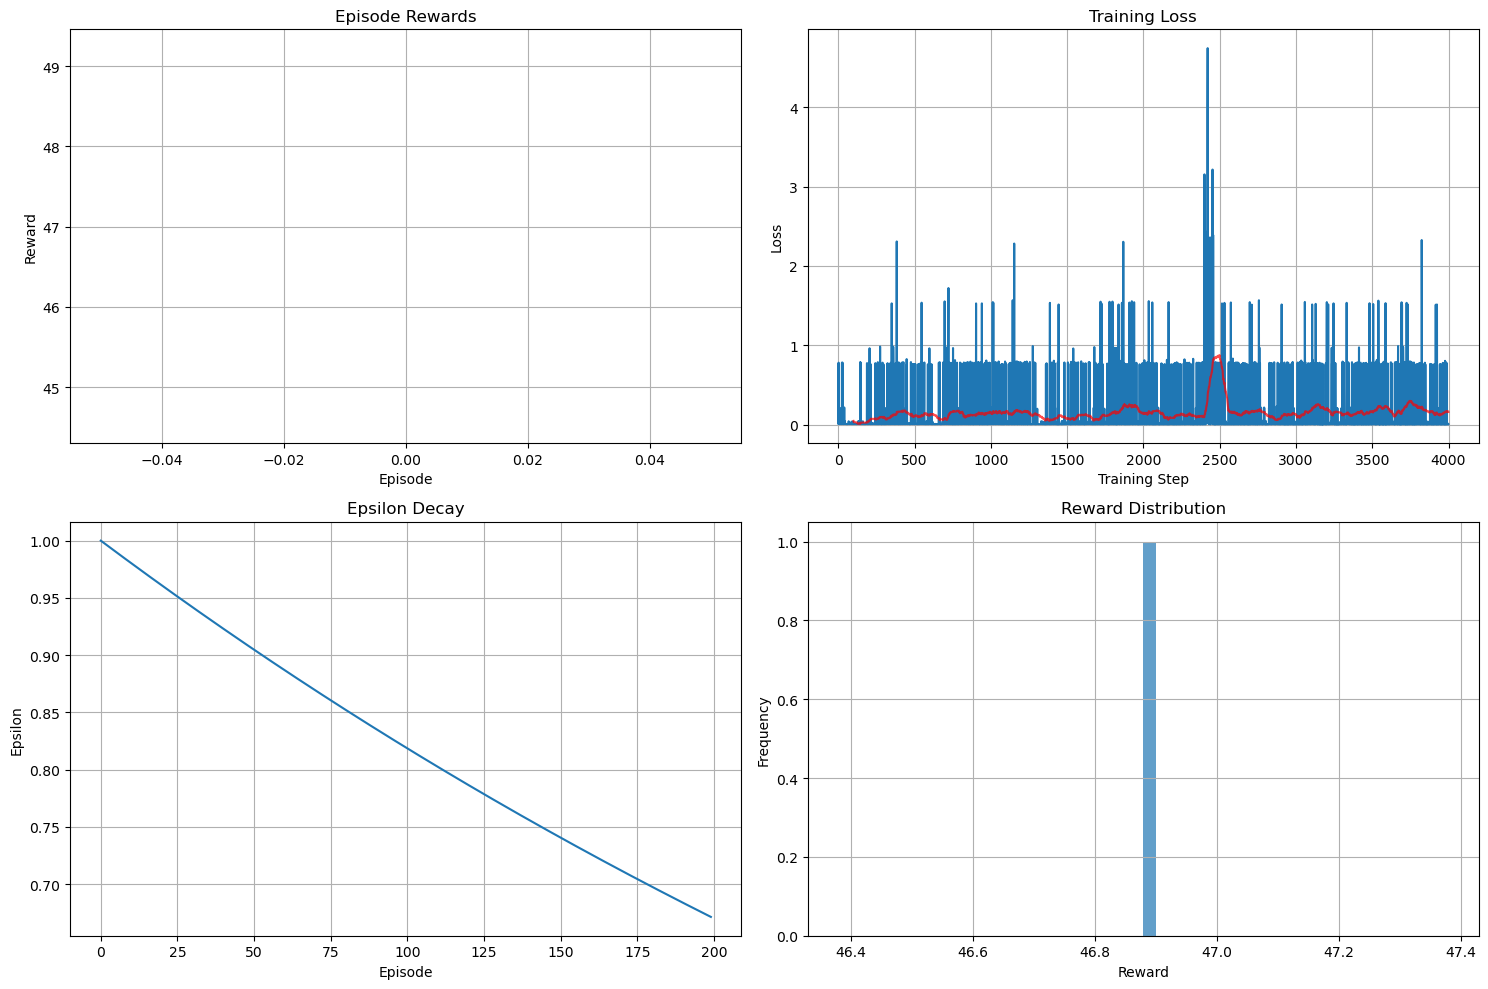

In [19]:
plot_training_metrics(get_avg_reward(reward_history, episodes=0), q_loss_list, epsilon_history)

Enabling replays!
Final evaluation - Total reward: 891.0
Disabling replays!
Animation saved to 2025-06-22_13-09-16_891.mp4


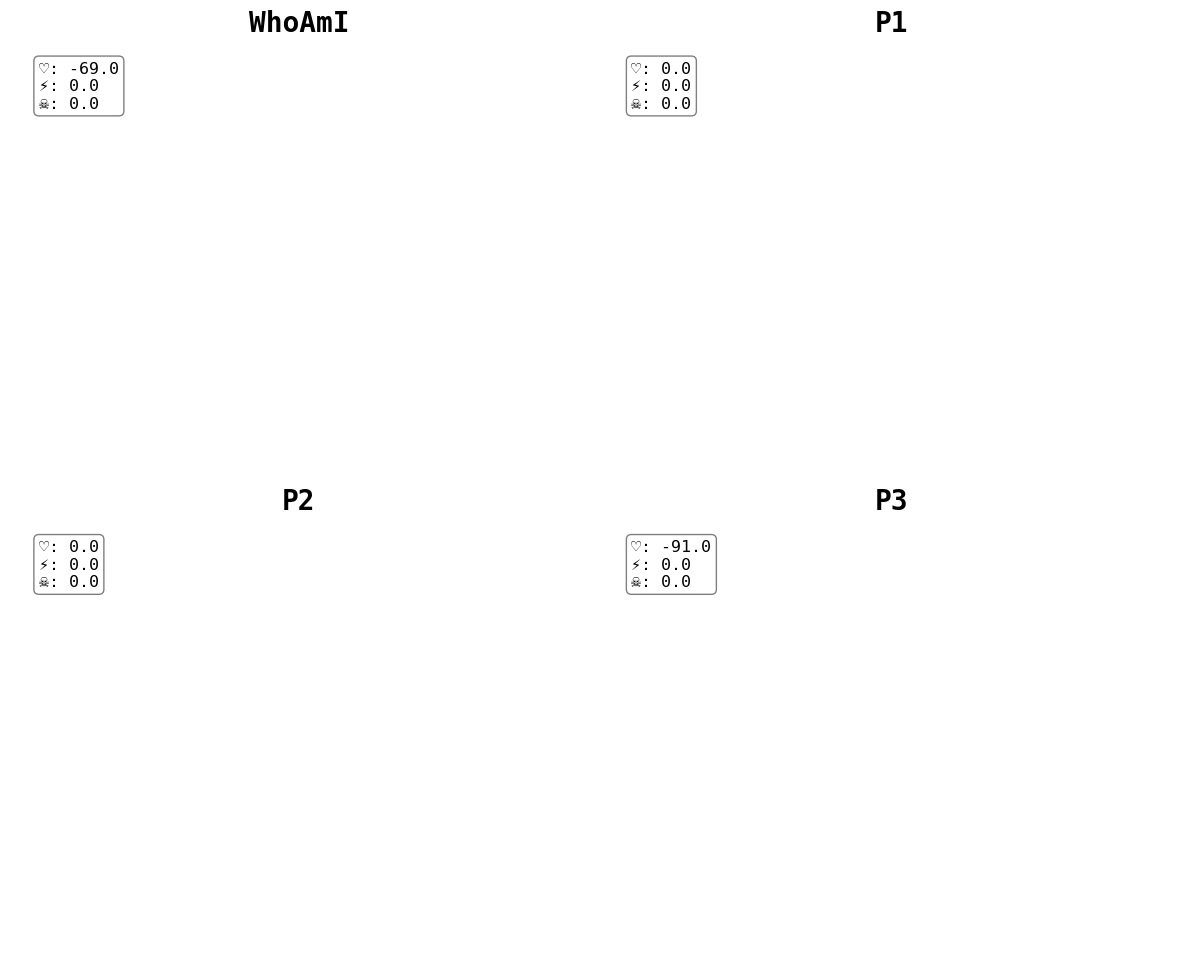

In [20]:
replay_episode(env, final_model.cpu(), device, DTYPE, store=True, random_player=False)